<a href="https://colab.research.google.com/github/20fh00/ProjectData/blob/main/FinalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import the all the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
plt.style.use('ggplot')

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unprocessed version of analysis to discover any bias
url = "/content/drive/MyDrive/credit_card_approval.xlsx"
df = pd.read_excel(url)

In [120]:
df2 = df.copy()

In [78]:
# Summary of the dataset/ EDA
df2.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,5065438,F,Y,N,2+ children,270000.0,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,-6,C,0
1,5142753,F,N,N,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,-17876,-377,1,1,1,0,Private service staff,-4,0,0
2,5111146,M,Y,Y,No children,270000.0,Higher education,Married,House / apartment,-19579,-1028,1,0,1,0,Laborers,0,C,0
3,5010310,F,Y,Y,1 children,112500.0,Secondary / secondary special,Married,House / apartment,-15109,-1956,1,0,0,0,Core staff,-3,0,0
4,5010835,M,Y,Y,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,-17281,-5578,1,1,0,0,Drivers,-29,0,0


In [79]:
print(df2.shape,"\n")
print(df2.columns,"\n")
print(df2.info(),"\n")

(537667, 19) 

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'JOB', 'BEGIN_MONTHS',
       'STATUS', 'TARGET'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537667 entries, 0 to 537666
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   537667 non-null  int64  
 1   CODE_GENDER          537667 non-null  object 
 2   FLAG_OWN_CAR         537667 non-null  object 
 3   FLAG_OWN_REALTY      537667 non-null  object 
 4   CNT_CHILDREN         537667 non-null  object 
 5   AMT_INCOME_TOTAL     537667 non-null  float64
 6   NAME_EDUCATION_TYPE  537667 non-null  object 
 7   NAME_FAMILY_STATUS   537667 non-null  object 
 8   NAME_H

In [80]:
num_cols = [col for col in df2.columns if df2[col].dtype in ['int64', 'float64']]
num_desc = df2[num_cols].describe ()
print(num_desc)

                 ID  AMT_INCOME_TOTAL     DAYS_BIRTH  DAYS_EMPLOYED  \
count  5.376670e+05      5.376670e+05  537667.000000  537667.000000   
mean   5.079231e+06      1.971171e+05  -15010.958999   -2762.029935   
std    4.200200e+04      1.041390e+05    3416.418092    2393.919456   
min    5.008806e+06      2.700000e+04  -24611.000000  -15713.000000   
25%    5.044925e+06      1.350000e+05  -17594.000000   -3661.000000   
50%    5.079091e+06      1.800000e+05  -14785.000000   -2147.000000   
75%    5.115755e+06      2.295000e+05  -12239.000000   -1050.000000   
max    5.150487e+06      1.575000e+06   -7489.000000     -17.000000   

       FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE     FLAG_EMAIL  \
count    537667.0    537667.000000  537667.000000  537667.000000   
mean          1.0         0.281615       0.298893       0.100730   
std           0.0         0.449787       0.457773       0.300971   
min           1.0         0.000000       0.000000       0.000000   
25%           1.0   

In [81]:
risk_applicant = df2[df2['TARGET'] == 1]['TARGET'].value_counts().get(1, 0)
approval = df2[df2['TARGET'] == 0]['TARGET'].value_counts().get(0, 0)
print("Number of risk applications:", risk_applicant)
print("Number of approved applications:", approval)

Number of credit card risk applications: 1962
Number of credit card approved applications: 535705


In [82]:
# Detect any missing values
df2.isnull().values.any()

False

In [83]:
# Detect any duplicates
duplicates = df2.duplicated().any()
if duplicates:
    print("Duplicates found in the DataFrame.")
else:
    print("No duplicates in the DataFrame.")

No duplicates in the DataFrame.


In [84]:
# Identify any skewed features
df2.skew()

<ipython-input-84-0d601fce7238>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.skew()


ID                   0.044074
AMT_INCOME_TOTAL     2.773886
DAYS_BIRTH          -0.238675
DAYS_EMPLOYED       -1.667880
FLAG_MOBIL           0.000000
FLAG_WORK_PHONE      0.971064
FLAG_PHONE           0.878634
FLAG_EMAIL           2.653228
BEGIN_MONTHS        -0.604699
TARGET              16.463458
dtype: float64

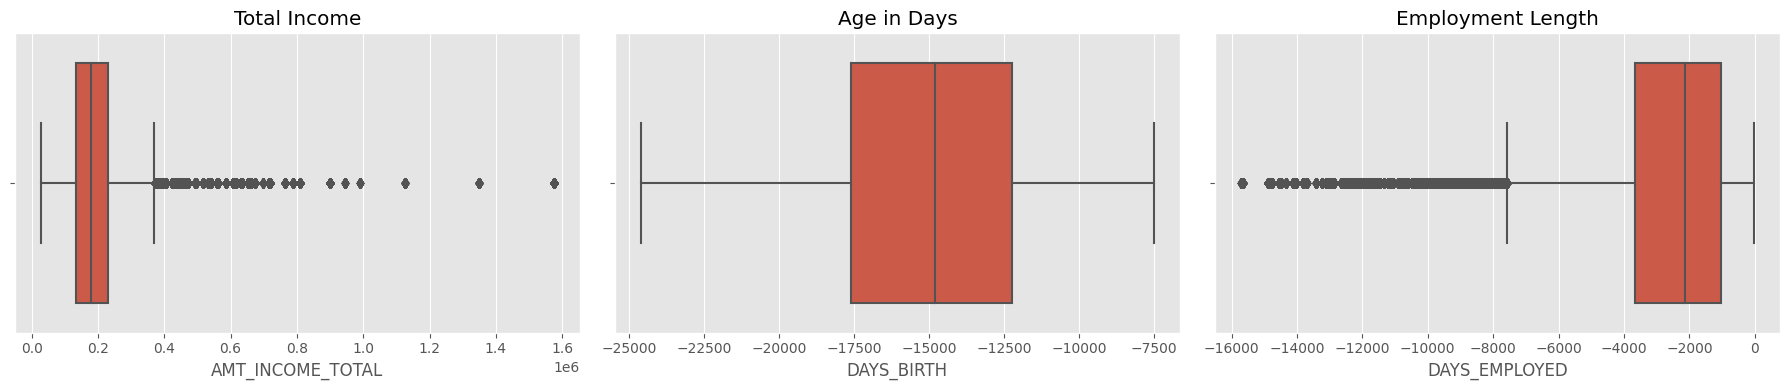

In [85]:
# Boxplots of continuous data
# Data visualisation
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18,4)
axes = axes.flatten()

sns.boxplot(x='AMT_INCOME_TOTAL', data=df2, ax=axes[0])
axes[0].set_title("Total Income")

sns.boxplot(x='DAYS_BIRTH', data=df2, ax=axes[1])
axes[1].set_title("Age in Days")

sns.boxplot(x='DAYS_EMPLOYED', data=df2, ax=axes[2])
axes[2].set_title("Employment Length")

plt.tight_layout()
plt.show()

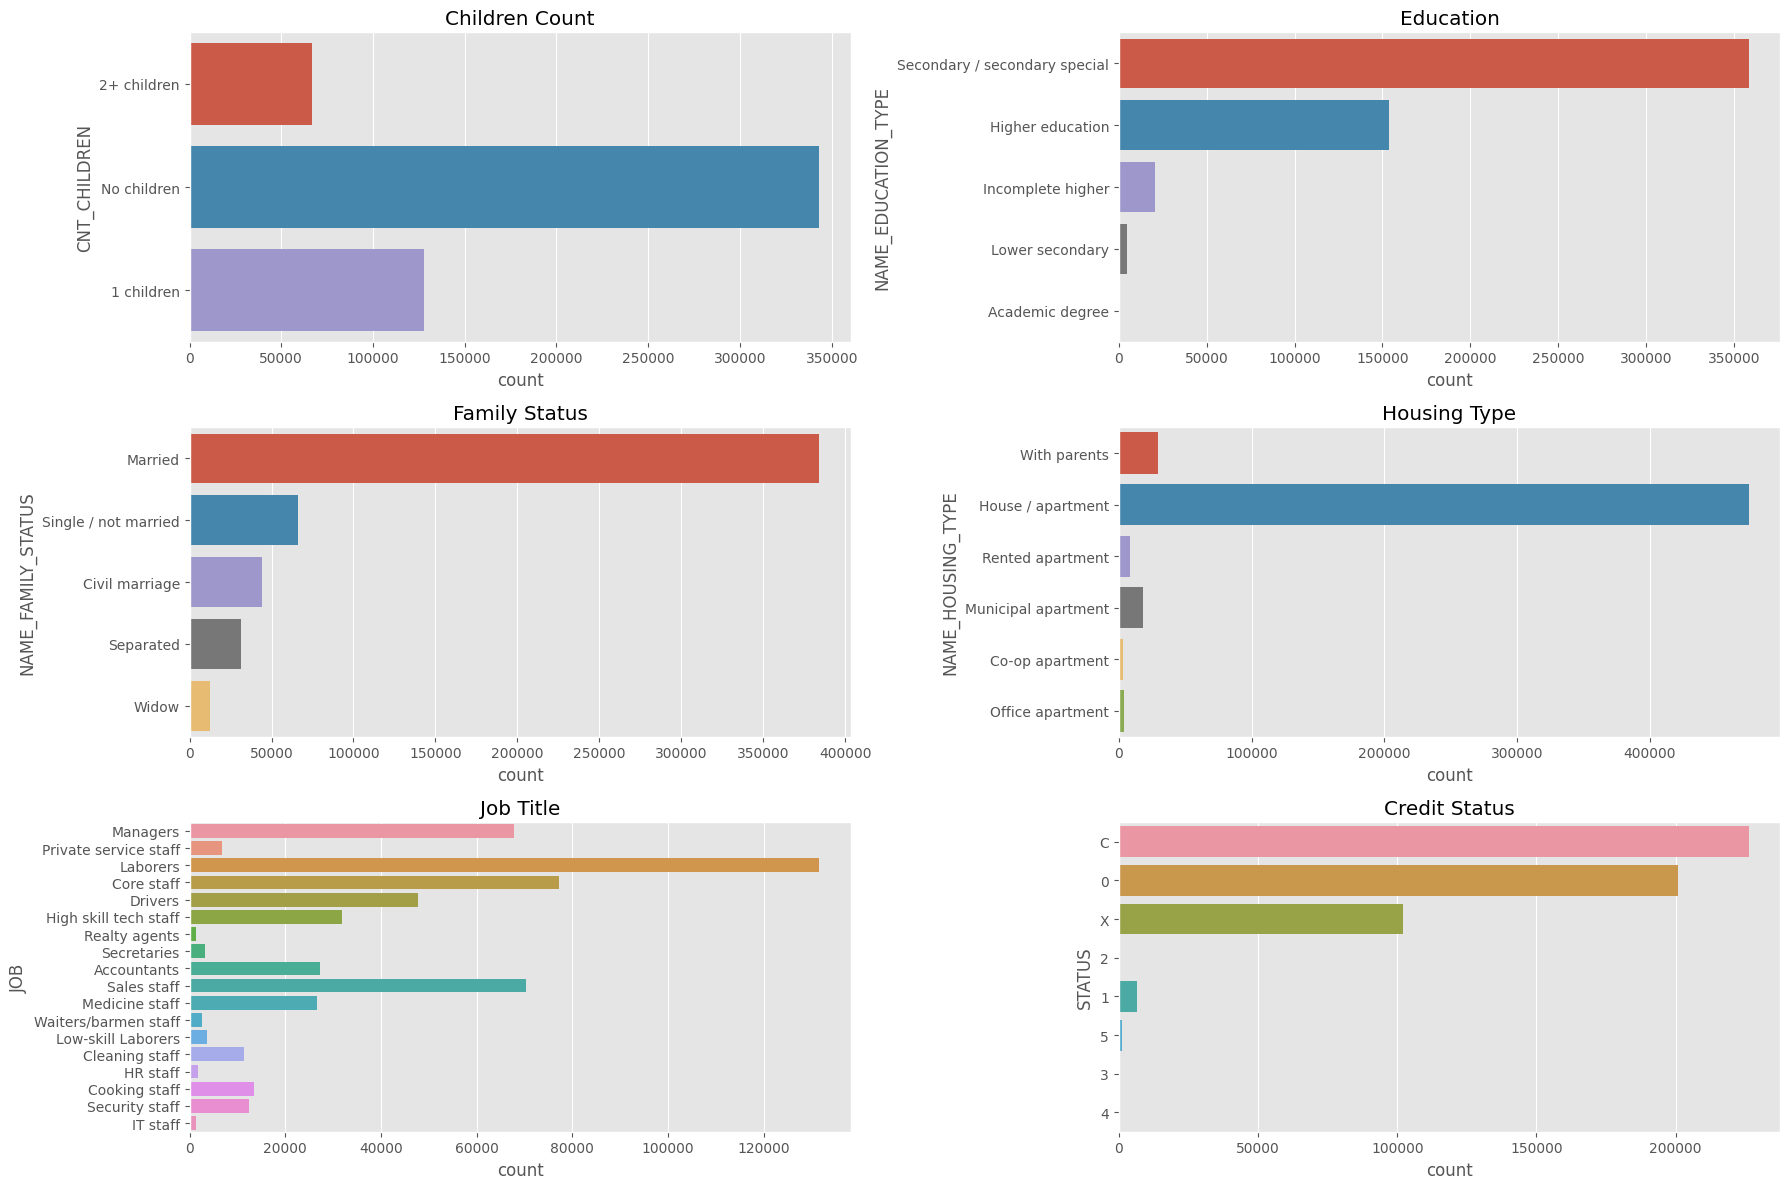

In [86]:
# Plot barcharts of categorical data
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(18,12)
axes = axes.flatten()

sns.countplot(y='CNT_CHILDREN', data=df2, ax=axes[0])
axes[0].set_title("Children Count")

sns.countplot(y='NAME_EDUCATION_TYPE', data=df2, ax=axes[1])
axes[1].set_title("Education")

sns.countplot(y='NAME_FAMILY_STATUS', data=df2, ax=axes[2])
axes[2].set_title("Family Status")

sns.countplot(y='NAME_HOUSING_TYPE', data=df2, ax=axes[3])
axes[3].set_title("Housing Type")

sns.countplot(y='JOB', data=df2, ax=axes[4])
axes[4].set_title("Job Title")

sns.countplot(y='STATUS', data=df2, ax=axes[5])
axes[5].set_title("Credit Status")

plt.tight_layout()
plt.show()

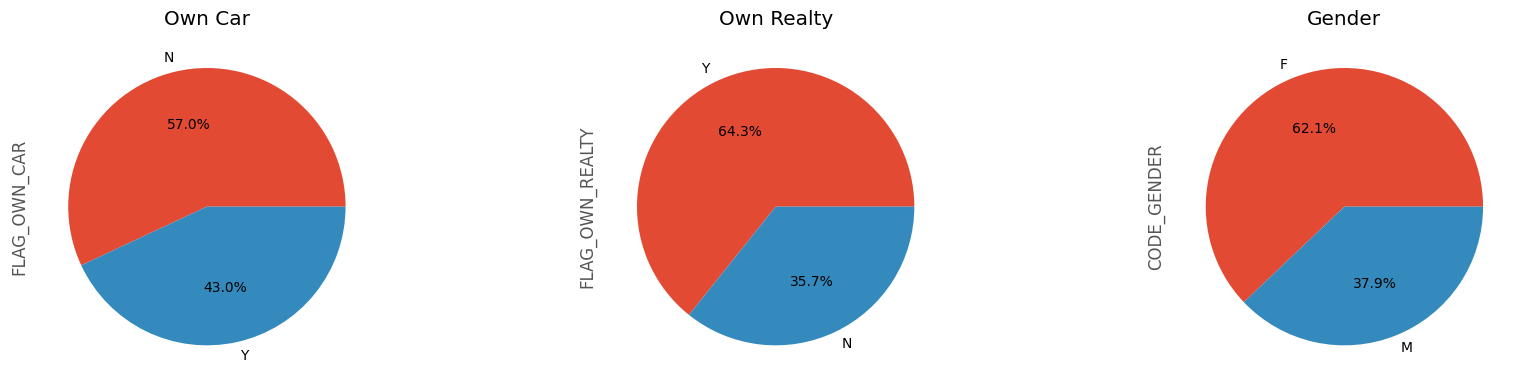

In [87]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18,4)

df2['FLAG_OWN_CAR'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0], legend=False)
axes[0].set_title("Own Car")

df2['FLAG_OWN_REALTY'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1], legend=False)
axes[1].set_title("Own Realty")

df2['CODE_GENDER'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[2], legend=False)
axes[2].set_title("Gender")

plt.tight_layout()
plt.show()

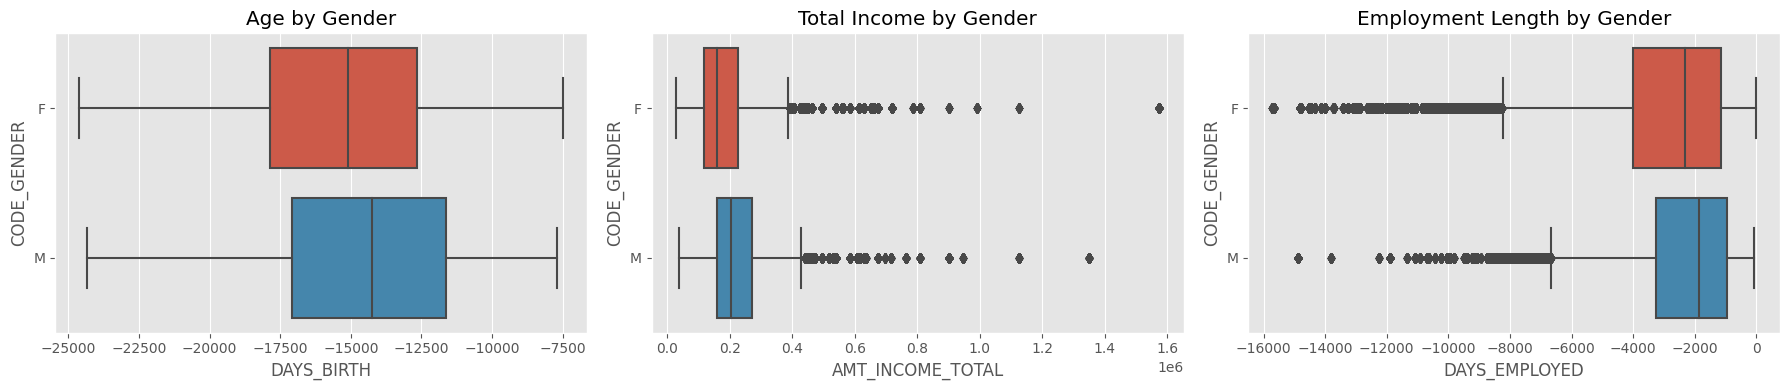

In [88]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18,4)
axes = axes.flatten()

sns.boxplot(x='DAYS_BIRTH', y='CODE_GENDER', data=df2, ax=axes[0])
axes[0].set_title("Age by Gender")

sns.boxplot(x='AMT_INCOME_TOTAL', y='CODE_GENDER', data=df2, ax=axes[1])
axes[1].set_title("Total Income by Gender")

sns.boxplot(x='DAYS_EMPLOYED', y='CODE_GENDER', data=df2, ax=axes[2])
axes[2].set_title("Employment Length by Gender")

plt.tight_layout()
plt.show()

In [89]:
# Count the number of loan approvals and disapprovals by gender
loan_approvals_by_gender = df2[df2['TARGET'] == 0]['CODE_GENDER'].value_counts()
loan_disapprovals_by_gender = df2[df2['TARGET'] == 1]['CODE_GENDER'].value_counts()

# Print the counts
print("Loan Approvals by Gender:")
print(loan_approvals_by_gender)

print("\nLoan Disapprovals by Gender:")
print(loan_disapprovals_by_gender)

Loan Approvals by Gender:
F    332877
M    202828
Name: CODE_GENDER, dtype: int64

Loan Disapprovals by Gender:
M    1007
F     955
Name: CODE_GENDER, dtype: int64


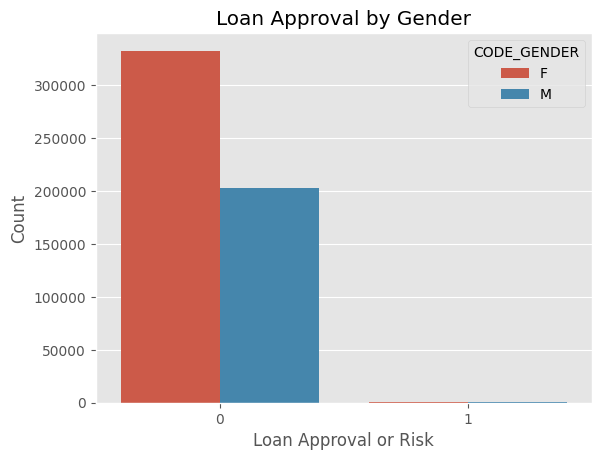

In [90]:
sns.countplot(x='TARGET', hue='CODE_GENDER', data=df2)
plt.title('Loan Approval by Gender')
plt.xlabel('Loan Approval or Risk')
plt.ylabel('Count')
plt.show()

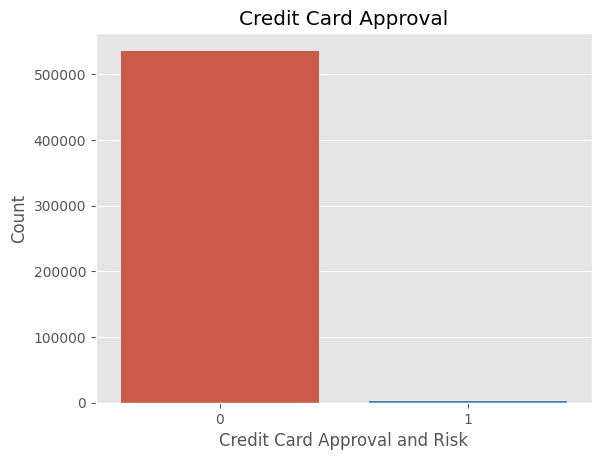

In [91]:
sns.countplot(x='TARGET', data=df2)
plt.title("Credit Card Approval")
plt.xlabel("Credit Card Approval and Risk")
plt.ylabel("Count")
plt.show()

In [92]:
contingency_table = pd.crosstab(df2['TARGET'], df2['CODE_GENDER'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("p-value:", p)

contingency_table = pd.crosstab(df2['TARGET'], df2['JOB'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("p-value:", p)

contingency_table = pd.crosstab(df2['TARGET'], df2['NAME_EDUCATION_TYPE'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("p-value:", p)

contingency_table = pd.crosstab(df2['TARGET'], df2['CNT_CHILDREN'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("p-value:", p)

contingency_table = pd.crosstab(df2['TARGET'], df2['NAME_HOUSING_TYPE'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("p-value:", p)

contingency_table = pd.crosstab(df2['TARGET'], df2['NAME_FAMILY_STATUS'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("p-value:", p)

p-value: 1.7667562323199451e-34
p-value: 7.782512719963732e-132
p-value: 5.161166610168622e-19
p-value: 2.911490124240846e-11
p-value: 9.253623067245047e-10
p-value: 1.0607740863942537e-37


In [93]:
correlation_matrix = df2[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'TARGET']].corr()
print(correlation_matrix)

                  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED    TARGET
AMT_INCOME_TOTAL          1.000000   -0.047838      -0.009500  0.002887
DAYS_BIRTH               -0.047838    1.000000       0.324231 -0.005401
DAYS_EMPLOYED            -0.009500    0.324231       1.000000  0.019230
TARGET                    0.002887   -0.005401       0.019230  1.000000


In [141]:
df2 = pd.get_dummies(df2, drop_first=False)

In [142]:
X = df2.drop(['TARGET'], axis=1)
y = df2['TARGET']
# Split dataset into train and test sets (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
ss=StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [144]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [145]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [146]:
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression()
}
for key in models.keys():
    models[key].fit(X_train, y_train)
    pred = models[key].predict(X_test)
    print(key)
    print(classification_report(y_test, pred))

RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107157
           1       1.00      1.00      1.00       377

    accuracy                           1.00    107534
   macro avg       1.00      1.00      1.00    107534
weighted avg       1.00      1.00      1.00    107534

LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107157
           1       1.00      1.00      1.00       377

    accuracy                           1.00    107534
   macro avg       1.00      1.00      1.00    107534
weighted avg       1.00      1.00      1.00    107534



In [11]:
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression()
}
df2_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    df2_model.loc[model_name] = [accuracy, precision, recall, f1]

print(df2_model)

                    Accuracy Precision Recall   F1
RandomForest             1.0       1.0    1.0  1.0
LogisticRegression  0.996367       0.0    0.0  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
rf_y_pred = rf_model.predict(X_test)
lr_y_pred = lr_model.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, rf_y_pred)
conf_matrix_lr = confusion_matrix(y_test, lr_y_pred)
print("RF Confusion Matrix:")
print(conf_matrix_rf)
print("LR Confusion Matrix:")
print(conf_matrix_lr)

RF Confusion Matrix:
[[160715      0]
 [     0    586]]
LR Confusion Matrix:
[[160715      0]
 [   586      0]]


In [150]:
feat_importances = pd.Series(models['RandomForest'].feature_importances_, index=X.columns)
top_feature_importances = feat_importances.nlargest(25)
print(top_feature_importances)

STATUS_5                                             0.449985
STATUS_2                                             0.230837
STATUS_3                                             0.072161
STATUS_4                                             0.059832
STATUS_1                                             0.046159
ID                                                   0.020015
STATUS_C                                             0.019367
STATUS_0                                             0.016096
BEGIN_MONTHS                                         0.014056
STATUS_X                                             0.010521
DAYS_EMPLOYED                                        0.010431
DAYS_BIRTH                                           0.009891
AMT_INCOME_TOTAL                                     0.008088
NAME_FAMILY_STATUS_Married                           0.002068
JOB_Security staff                                   0.001998
FLAG_PHONE                                           0.001858
FLAG_OWN

<Axes: >

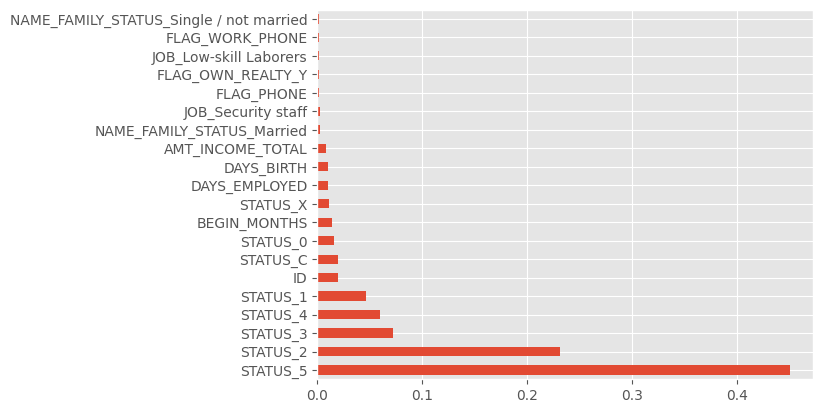

In [151]:
feat_importances = pd.Series(models['RandomForest'].feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [148]:
model = lr_model
coefficients = model.coef_[0]
absolute_coefficients = np.abs(coefficients)
feature_names = X.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': absolute_coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
top_n = 20
top_features = feature_importance.head(top_n)
print(top_features)

                                    Feature  Importance
57                                 STATUS_5    1.141691
54                                 STATUS_2    0.778185
55                                 STATUS_3    0.453009
56                                 STATUS_4    0.410934
58                                 STATUS_C    0.077363
52                                 STATUS_0    0.070905
59                                 STATUS_X    0.045907
50                       JOB_Security staff    0.027481
3                             DAYS_EMPLOYED    0.022276
0                                        ID    0.020490
43                   JOB_Low-skill Laborers    0.019386
10                            CODE_GENDER_M    0.017145
9                             CODE_GENDER_F    0.017145
23        NAME_FAMILY_STATUS_Civil marriage    0.016169
26  NAME_FAMILY_STATUS_Single / not married    0.015859
41                             JOB_IT staff    0.013232
21      NAME_EDUCATION_TYPE_Lower secondary    0

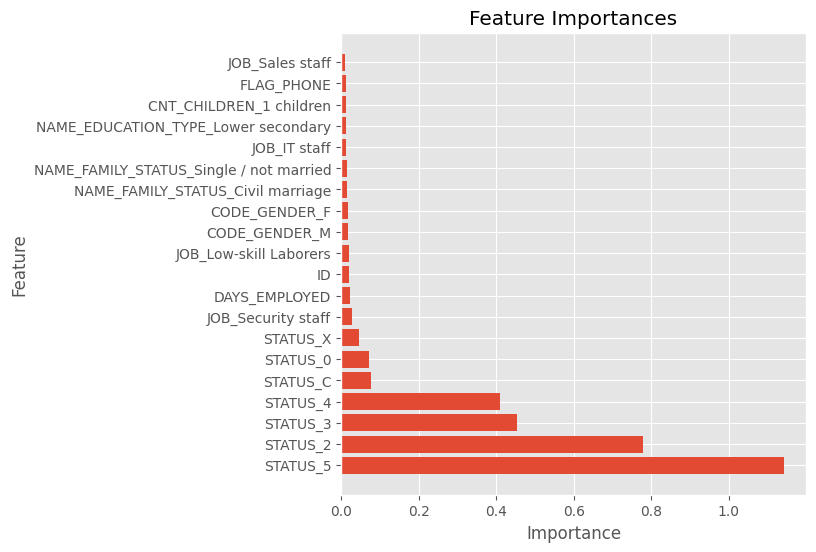

In [149]:
plt.figure(figsize=(6, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

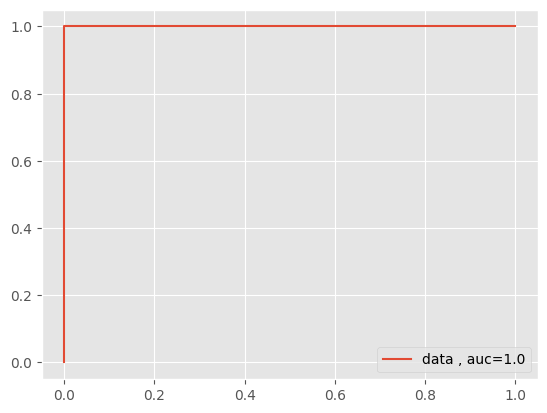

In [113]:
y_prob = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="data , auc="+str(auc))
plt.legend(loc=4)
plt.show()

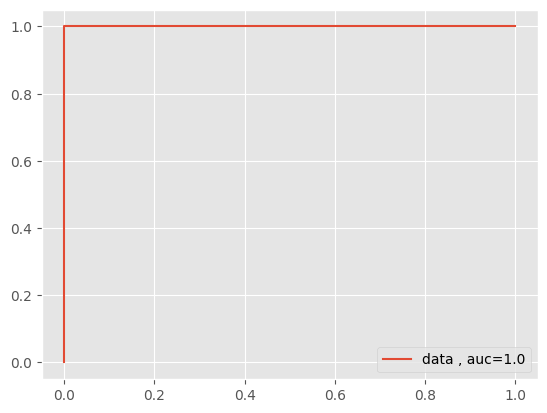

In [114]:
y_prob = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="data , auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [102]:
df3 = df.copy()

In [103]:
df3['DAYS_BIRTH'] = df3['DAYS_BIRTH'].abs()
print(df3['DAYS_BIRTH'])

0         13258
1         17876
2         19579
3         15109
4         17281
          ...  
537662    12372
537663    14160
537664    24204
537665    22647
537666    20082
Name: DAYS_BIRTH, Length: 537667, dtype: int64


In [104]:
df3['DAYS_EMPLOYED'] = df3['DAYS_EMPLOYED'].abs()
print(df3['DAYS_EMPLOYED'])

0         2300
1          377
2         1028
3         1956
4         5578
          ... 
537662    5401
537663    4635
537664    2462
537665    3847
537666    4979
Name: DAYS_EMPLOYED, Length: 537667, dtype: int64


In [105]:
df3['BEGIN_MONTHS'] = df3['BEGIN_MONTHS'].abs()
print(df3['BEGIN_MONTHS'])

0          6
1          4
2          0
3          3
4         29
          ..
537662     8
537663     8
537664     7
537665     1
537666    45
Name: BEGIN_MONTHS, Length: 537667, dtype: int64


In [106]:
df3.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,5065438,F,Y,N,2+ children,270000.0,Secondary / secondary special,Married,With parents,13258,2300,1,0,0,0,Managers,6,C,0
1,5142753,F,N,N,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,17876,377,1,1,1,0,Private service staff,4,0,0
2,5111146,M,Y,Y,No children,270000.0,Higher education,Married,House / apartment,19579,1028,1,0,1,0,Laborers,0,C,0
3,5010310,F,Y,Y,1 children,112500.0,Secondary / secondary special,Married,House / apartment,15109,1956,1,0,0,0,Core staff,3,0,0
4,5010835,M,Y,Y,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,17281,5578,1,1,0,0,Drivers,29,0,0


In [107]:
X = df3.drop(['TARGET', 'ID', 'STATUS', 'CODE_GENDER'], axis=1)
y = df3['TARGET']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [109]:
!pip install category_encoders

In [110]:
import category_encoders as ce
one_hot_encode = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
X_train_encoded = pd.get_dummies(X_train, columns=one_hot_encode, drop_first=True)
#X_train_encoded = pd.get_dummies(X_train_encoded, columns=['CODE_GENDER'], drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=one_hot_encode, drop_first=True)
#X_test_encoded = pd.get_dummies(X_test_encoded, columns=['CODE_GENDER'], drop_first=False)
target_encode = ['CNT_CHILDREN', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'JOB']
encoder = ce.TargetEncoder()
X_train_encoded[target_encode] = encoder.fit_transform(X_train_encoded[target_encode], y_train)
X_test_encoded[target_encode] = encoder.transform(X_test_encoded[target_encode])

In [111]:
columns_to_transform = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'BEGIN_MONTHS']
X_train_encoded[columns_to_transform] = np.log1p(X_train_encoded[columns_to_transform])
X_test_encoded[columns_to_transform] = np.log1p(X_test_encoded[columns_to_transform])

In [112]:
lr_model = LogisticRegression()
rfe = RFE(lr_model, n_features_to_select=15)
X_train_selected = rfe.fit_transform(X_train_encoded, y_train)
X_test_selected = rfe.transform(X_test_encoded)
selected_feature_names = X_train_encoded.columns[rfe.support_]
print("Selected Features:")
print(selected_feature_names)

Selected Features:
Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'JOB', 'BEGIN_MONTHS', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_Y'],
      dtype='object')


In [113]:
pip install imbalanced-learn

In [114]:
smote = SMOTE(random_state=42)
X_train_selected_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

In [115]:
X_train_selected_smote.shape, y_train_smote.shape

((535700, 15), (535700,))

In [97]:
scaler = RobustScaler()
X_train_selected_smote = scaler.fit_transform(X_train_selected_smote)
X_test_selected = scaler.transform(X_test_selected)

In [20]:
skewness = X_train_encoded.skew()
positive_skew = skewness[skewness > 1].index
X_train_encoded[positive_skew] = np.sqrt(X_train_encoded[positive_skew])

In [116]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_selected_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [117]:
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train_selected_smote, y_train_smote)

LogisticRegression(class_weight='balanced', random_state=42)

In [153]:
# Evaluate the RandomForestClassifier on the training data
rf_training_accuracy = rf_model.score(X_train_selected_smote, y_train_smote)
print("RandomForestClassifier Training Accuracy:", rf_training_accuracy)

RandomForestClassifier Training Accuracy: 0.999042641137097


In [154]:
# Evaluate the LogisticRegression on the training data
lr_training_accuracy = lr_model.score(X_train_selected_smote, y_train_smote)
print("LogisticRegression Training Accuracy:", lr_training_accuracy)

LogisticRegression Training Accuracy: 0.6334115576415371


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_model.fit(X_train_selected_smote, y_train_smote)
oob_score = rf_model.oob_score_
print("OOB score:", oob_score)

In [156]:
param_dist = {'n_estimators': [50, 100, 150],
              'max_depth': [5, 20],
              'min_samples_split': [2, 10],
              'min_samples_leaf': [1, 2],
              'max_features': ['sqrt', 'log2']
}

In [157]:
rf_model = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, cv=3, n_iter=5, random_state=42)

In [158]:
rf_search.fit(X_train_selected_smote, y_train_smote)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [5, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [159]:
print("Best Hyperparameters:", rf_search.best_params_)
print("Best Score:", rf_search.best_score_)

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best Score: 0.9943531838573553


In [160]:
lr_model = LogisticRegression(random_state=42)
lr_param_distributions = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [161]:
lr_random_search = RandomizedSearchCV(
    lr_model, param_distributions=lr_param_distributions,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    random_state=42
)
lr_random_search.fit(X_train_selected_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42)

In [162]:
best_params = lr_random_search.best_params_
best_lr_model = lr_random_search.best_estimator_
print("Best Hyperparameters:", best_params)
print("Best estimator", best_lr_model)

Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
Best estimator LogisticRegression(C=100, random_state=42, solver='liblinear')


In [163]:
best_rf_model = RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(best_rf_model, X_train_selected_smote, y_train_smote, cv=stratified_kfold, scoring='accuracy')
print("Random Forest Cross-Validation Scores:", rf_scores)
print("Mean RF Score:", rf_scores.mean())

Random Forest Cross-Validation Scores: [0.99445319 0.99447985 0.99471319 0.99455985 0.99436652]
Mean RF Score: 0.9945145203872103


In [165]:
best_lr_model = LogisticRegression(solver='liblinear', penalty='l2', C=100)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_scores = cross_val_score(best_lr_model, X_train_selected_smote, y_train_smote, cv=stratified_kfold, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", lr_scores)
print("Mean LR Score:", lr_scores.mean())

Logistic Regression Cross-Validation Scores: [0.64670391 0.64312382 0.64329715 0.64183712 0.64033041]
Mean LR Score: 0.6430584815595083


In [166]:
best_rf_model = RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, random_state=42)
best_lr_model = LogisticRegression(C=100, penalty='l2', solver='liblinear', random_state=42)

best_rf_model.fit(X_train_selected_smote, y_train_smote)
best_lr_model.fit(X_train_selected_smote, y_train_smote)

y_pred_rf = best_rf_model.predict(X_test_selected)
y_pred_lr = best_lr_model.predict(X_test_selected)

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Random Forest Confusion Matrix:
[[159083   1632]
 [   179    407]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    160715
           1       0.20      0.69      0.31       586

    accuracy                           0.99    161301
   macro avg       0.60      0.84      0.65    161301
weighted avg       1.00      0.99      0.99    161301


Logistic Regression Confusion Matrix:
[[109076  51639]
 [   266    320]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81    160715
           1       0.01      0.55      0.01       586

    accuracy                           0.68    161301
   macro avg       0.50      0.61      0.41    161301
weighted avg       0.99      0.68      0.80    161301



ROC AUC: 0.9446674306020907


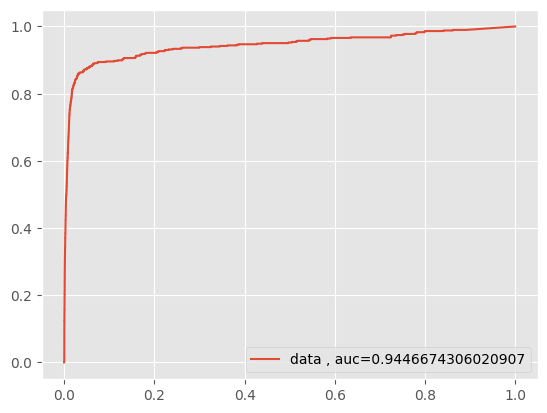

In [167]:
y_pred_prob_rf = best_rf_model.predict_proba(X_test_selected)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
print("ROC AUC:", roc_auc_rf)
auc = roc_auc_score(y_test, y_pred_prob_rf)
plt.plot(fpr_rf, tpr_rf,label="data , auc="+str(auc))
plt.legend(loc=4)
plt.show()

ROC AUC: 0.6634687524255676


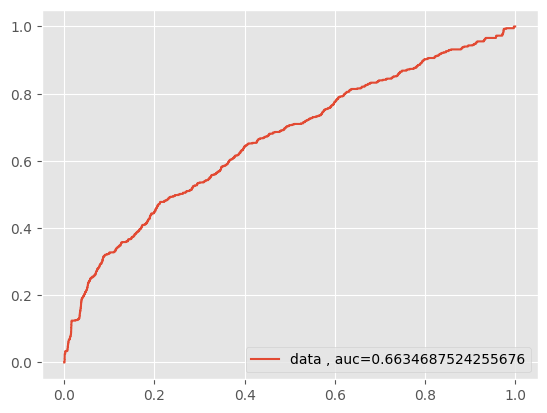

In [168]:
y_pred_prob_lr = best_lr_model.predict_proba(X_test_selected)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
print("ROC AUC:", roc_auc_lr)
auc = roc_auc_score(y_test, y_pred_prob_lr)
plt.plot(fpr_lr, tpr_lr,label="data , auc="+str(auc))
plt.legend(loc=4)
plt.show()

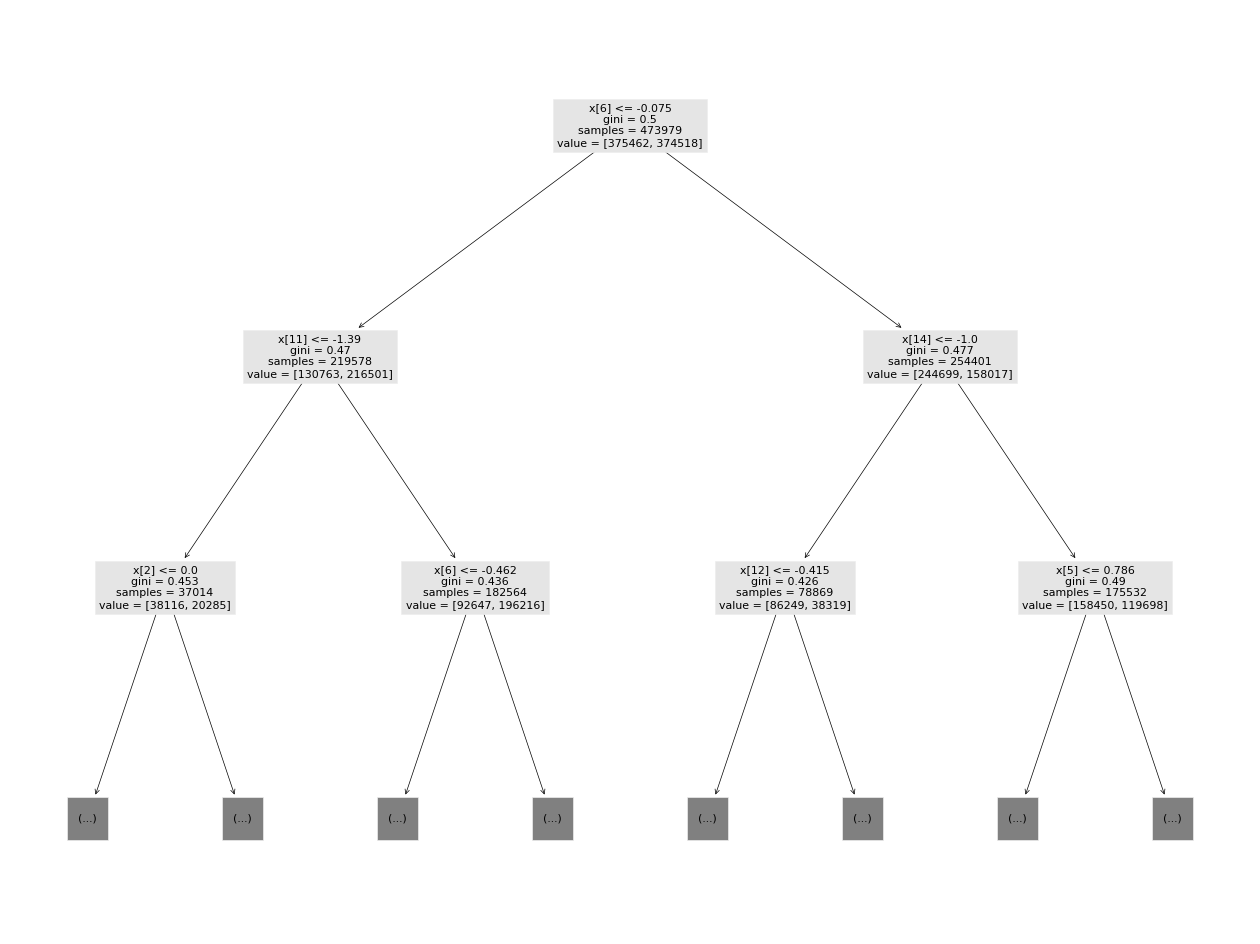

In [171]:
# Choose a valid index for the tree you want to plot (e.g., 0 for the first tree)
tree_index = 0

# Access the chosen tree from the best Random Forest model
chosen_tree = best_rf_model.estimators_[tree_index]

# Limit the depth of the tree for better visualization
max_depth = 2  # You can adjust this value as needed

# Plot the decision tree with limited depth
fig, ax = plt.subplots(figsize=(16, 12))
plot_tree(chosen_tree, ax=ax, max_depth=max_depth)
plt.show()


In [118]:
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression()
}
for key in models.keys():
    models[key].fit(X_train_selected_smote, y_train_smote)
    pred = models[key].predict(X_test_selected)
    print(key)
    print(classification_report(y_test, pred))

RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267855
           1       0.33      0.45      0.38       979

    accuracy                           0.99    268834
   macro avg       0.67      0.72      0.69    268834
weighted avg       1.00      0.99      1.00    268834

LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.65      0.79    267855
           1       0.01      0.56      0.01       979

    accuracy                           0.65    268834
   macro avg       0.50      0.61      0.40    268834
weighted avg       0.99      0.65      0.78    268834



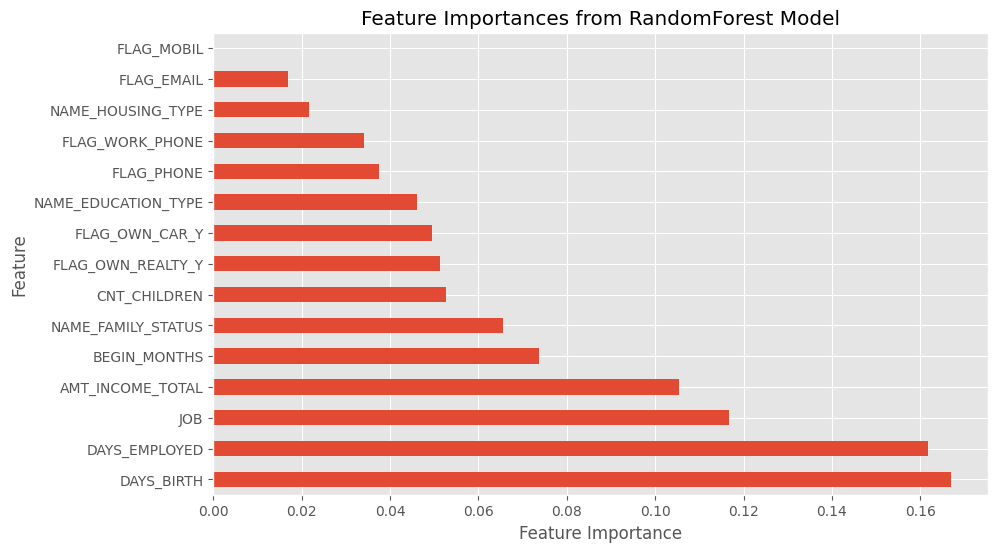

In [119]:
# Plot feature importances directly from the model
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf_model.feature_importances_, index=selected_feature_names)
#feat_importances = pd.Series(best_rf_model.feature_importances_, index=selected_feature_names)
feat_importances.nlargest(20).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Model')
plt.show()

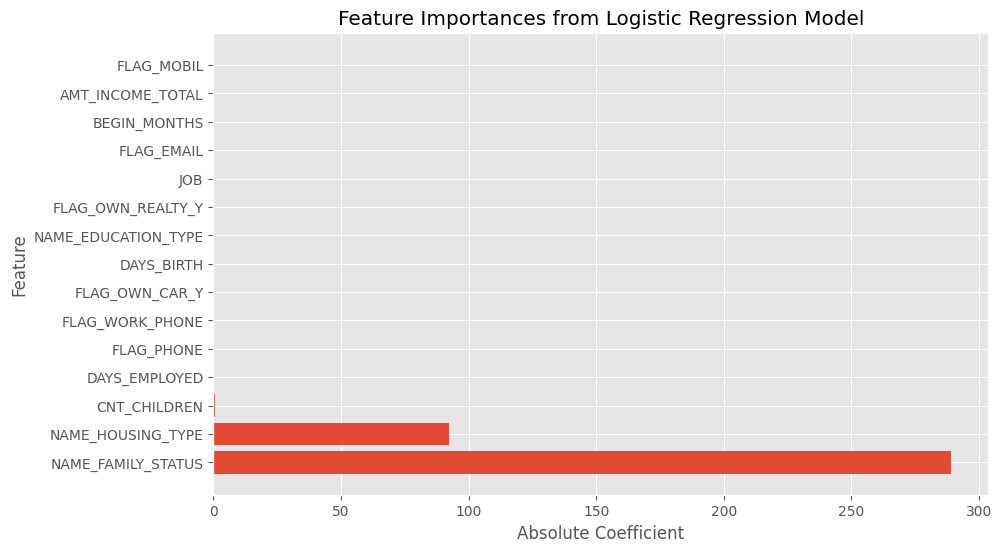

In [174]:
coefficients = best_lr_model.coef_[0]

# Create a DataFrame with feature names and their coefficients
feature_importances_df3 = pd.DataFrame({'Feature': selected_feature_names, 'Coefficient': coefficients})

# Sort feature importances by absolute coefficient value in descending order
feature_importances_df3['Absolute Coefficient'] = feature_importances_df3['Coefficient'].abs()
feature_importances_df3 = feature_importances_df3.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df3['Feature'], feature_importances_df3['Absolute Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances from Logistic Regression Model')
plt.show()